In [10]:
import os

import sys
sys.path.append('..')


from babilong.metrics import compare_answers, TASK_LABELS

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

In [32]:
def get_fname(results_folder, model_name, task, ctx_length, prompt_name):
    fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
    if not os.path.isfile(fname):
        fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}_chat_template_no.csv'
    if not os.path.isfile(fname):
        fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}_chat_template_yes.csv'
    if not os.path.isfile(fname):
        fname = None
    
    return fname

## Visualize evaluation results

In [33]:
results_folder = '../babilong_evals'

# find all model names in the results folder
model_names = []
model_dirs = next(os.walk(results_folder))[1]
for mn in model_dirs:
    mn_dir = os.path.join(results_folder, mn)
    subdirs = next(os.walk(mn_dir))[1]
    if len(subdirs) == 0:
        model_names.append(mn)
    else:
        for sd in subdirs:
            model_names.append(f"{mn}/{sd}")

print(model_names)

['01-ai/Yi-34B', '01-ai/Yi-34B-200k', '01-ai/Yi-9B-200k', 'NousResearch/Meta-Llama-3-8B-Instruct', 'NousResearch/Yarn-Mistral-7b-128k', 'RAG_Llama-3', 'gpt2', 'CohereForAI/c4ai-command-r-v01', 'ai21labs/Jamba-v0.1', 'microsoft/Phi-3-mini-128k-instruct', 'microsoft/Phi-3-medium-128k-instruct', 'mistralai/Mistral-7B-Instruct-v0.2', 'mistralai/Mistral-7B-Instruct-v0.2-qa1', 'mistralai/Mistral-7B-Instruct-v0.2-qa2', 'mistralai/Mixtral-8x22B-Instruct-v0.1', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'THUDM/chatglm3-6b-128k', 'Yukang/LongAlpaca-13B', 'lmsys/longchat-7b-v1.5-32k', 'namespace-Pt/activation-beacon-llama2-7b-chat', 'namespace-Pt/activation-beacon-mistral-7b', 'openai/gpt-4-0125-preview', 'openai/gpt-3.5-turbo-1106-qa1-1k', 'openai/gpt-3.5-turbo-1106', 'openai/gpt-3.5-turbo-1106-qa1-100', 'togethercomputer/LLaMA-2-7B-32K', 'togethercomputer/Llama-2-7B-32K-instruct']


In [34]:
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']#, '512k', '1M']

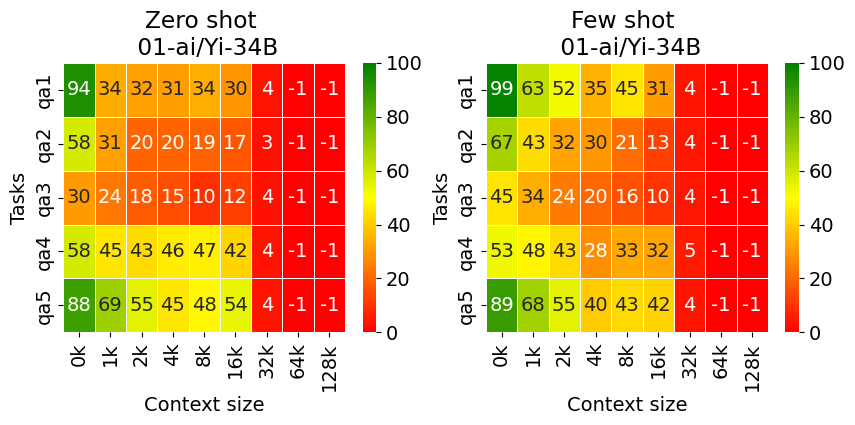

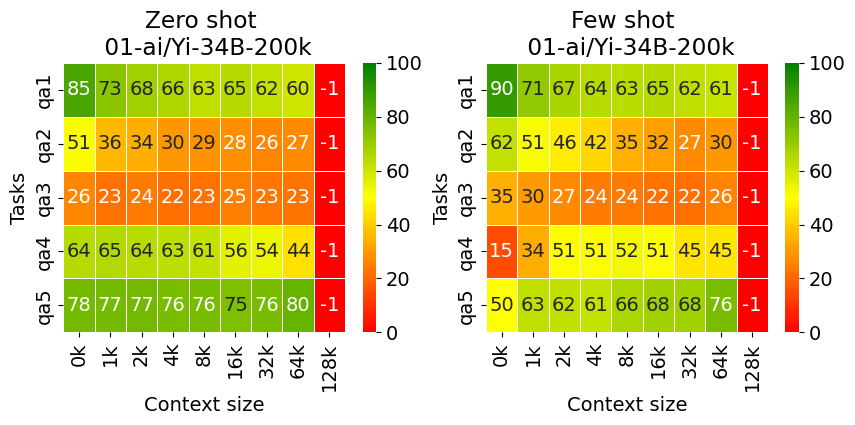

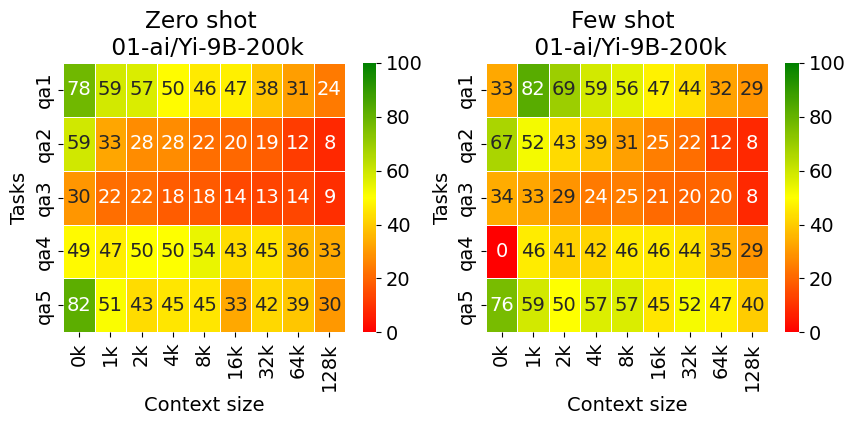

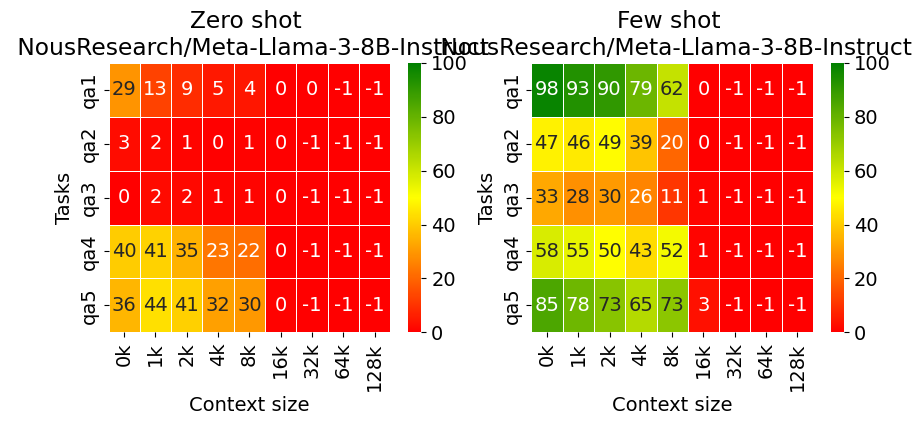

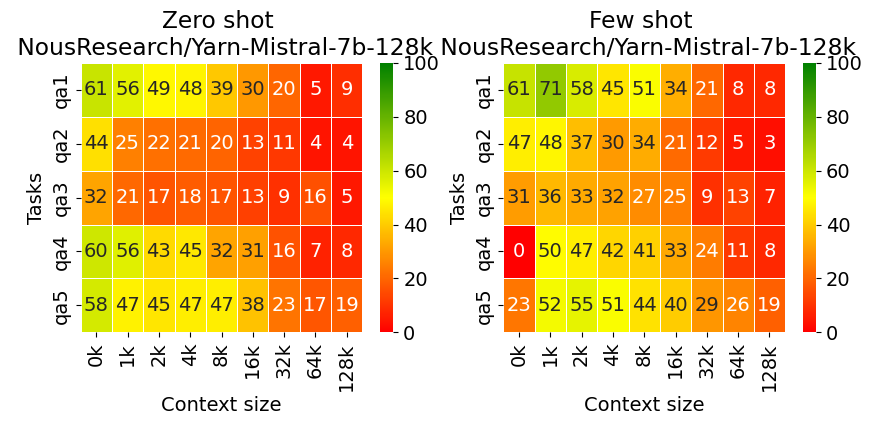

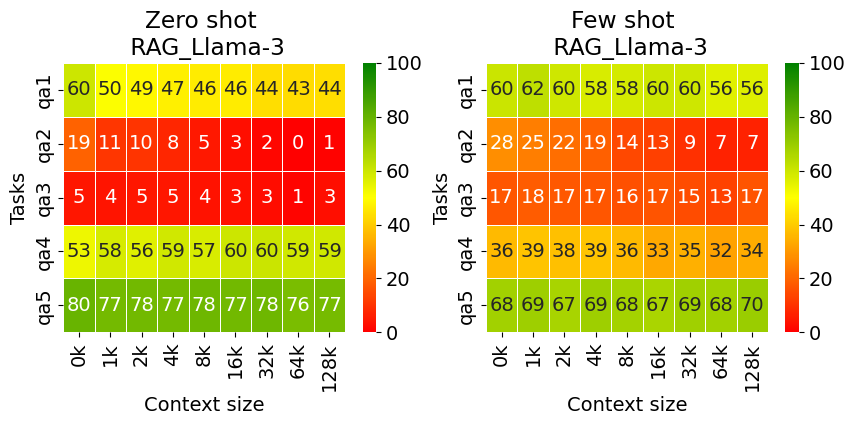

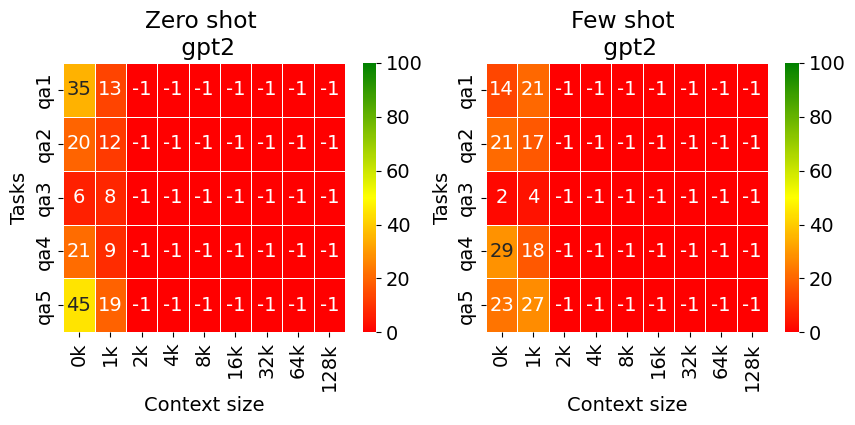

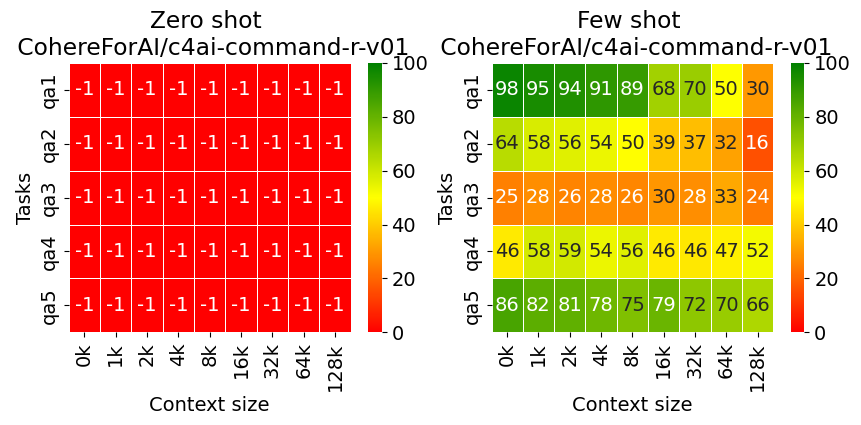

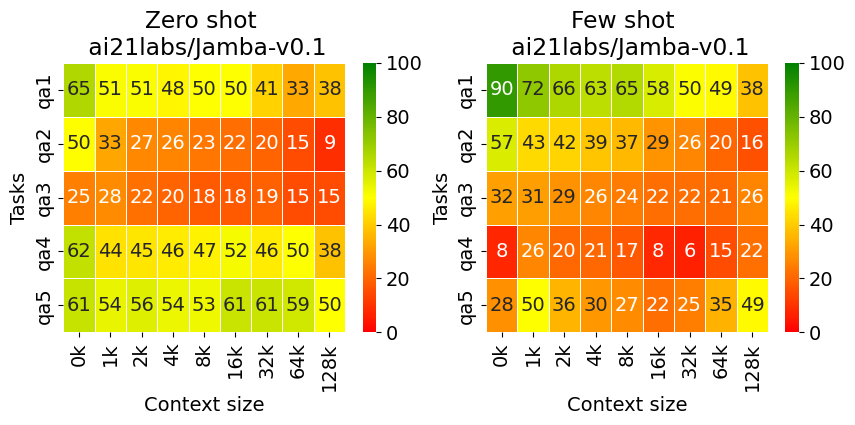

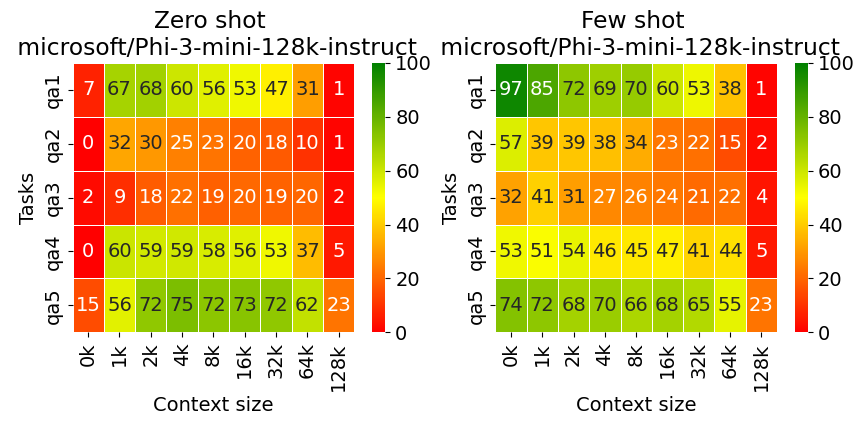

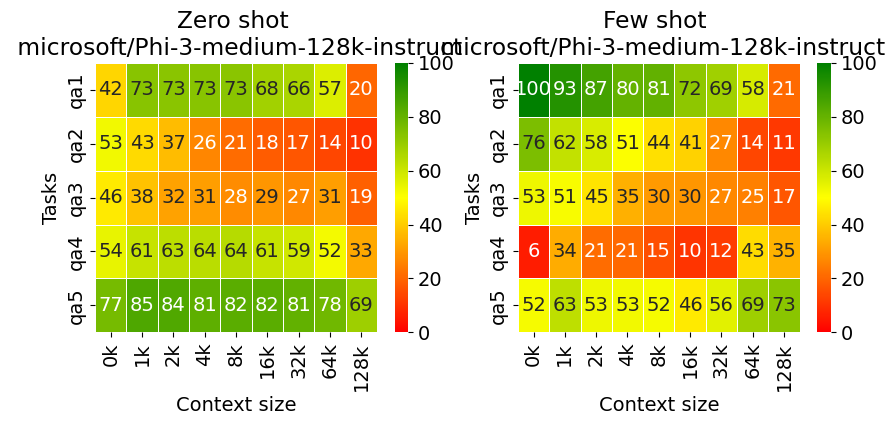

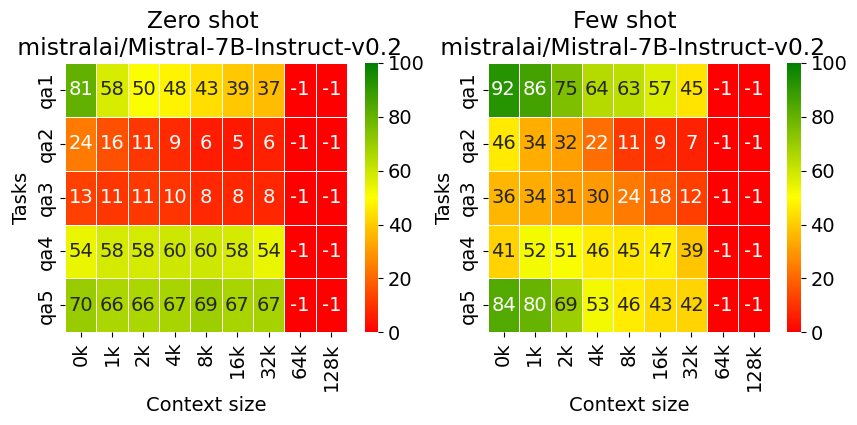

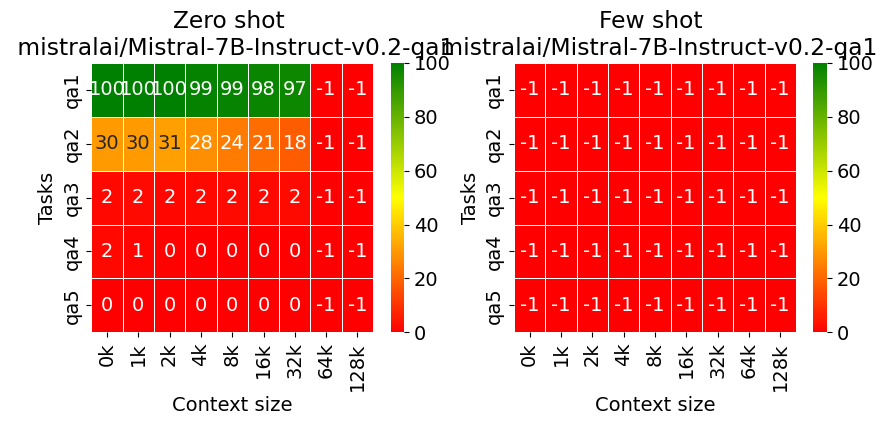

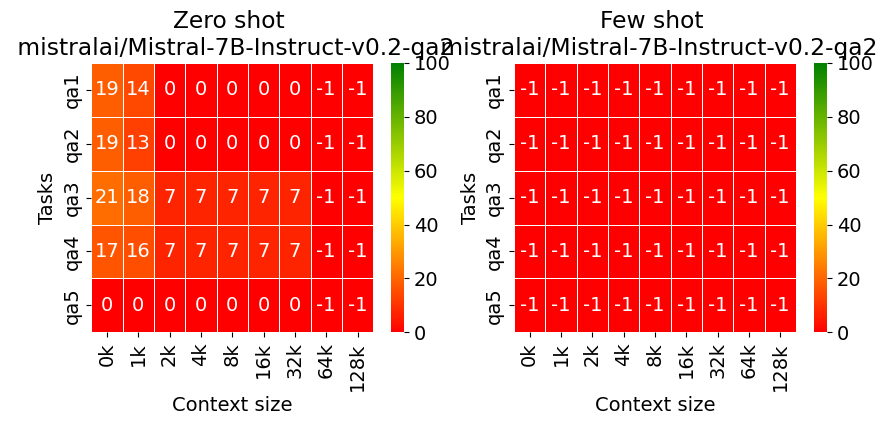

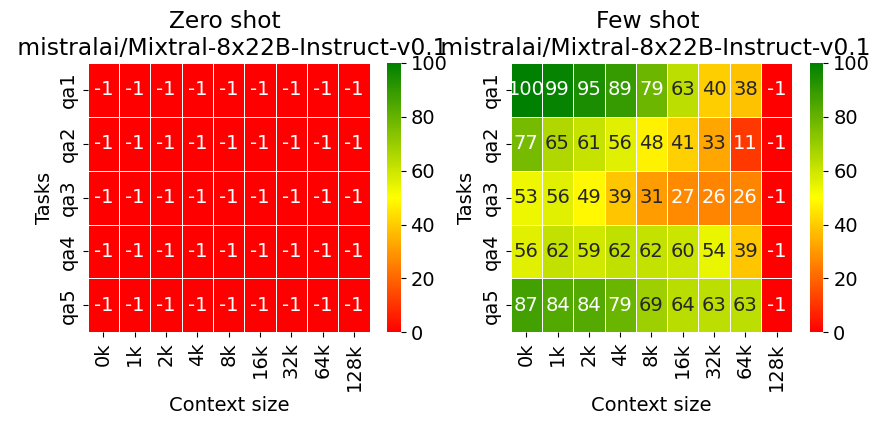

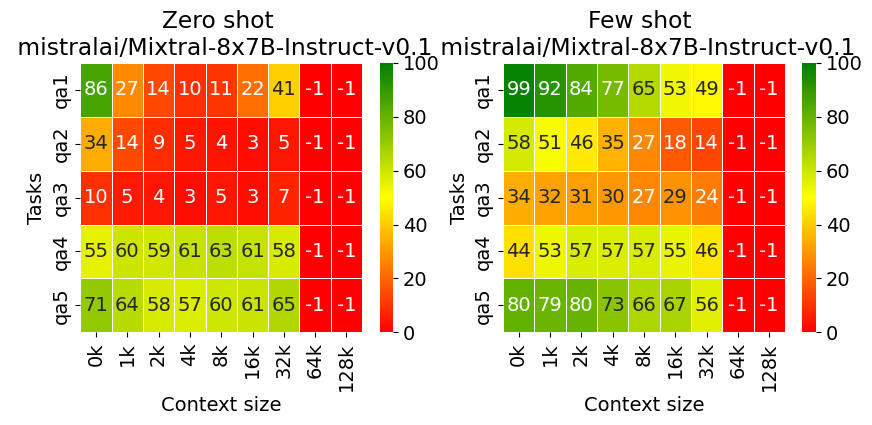

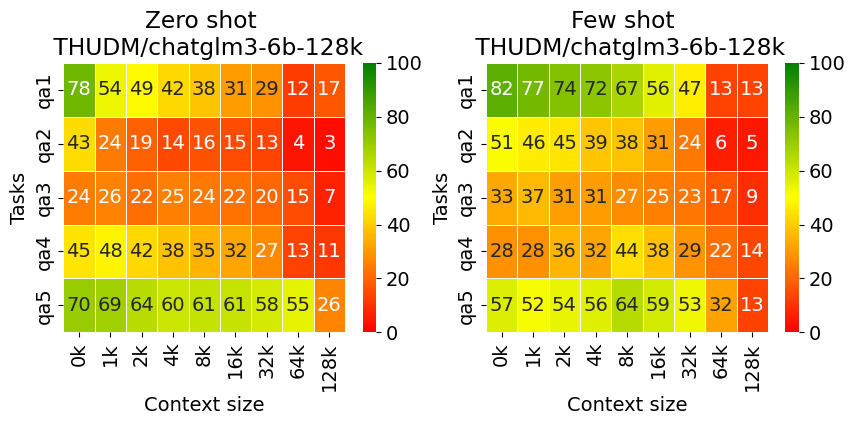

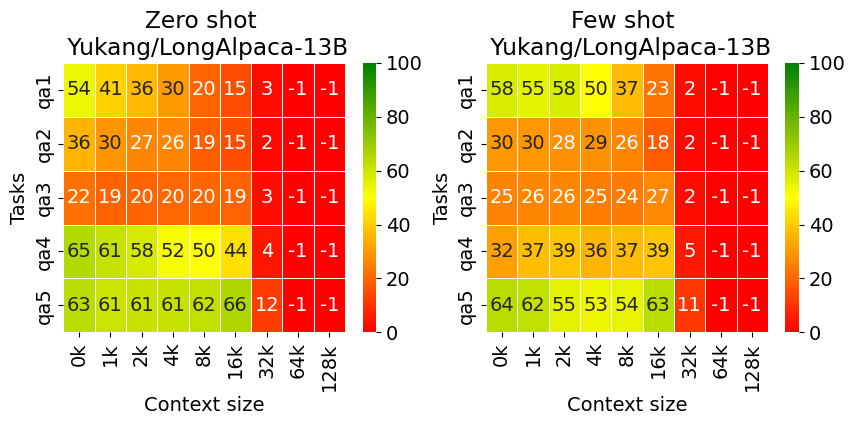

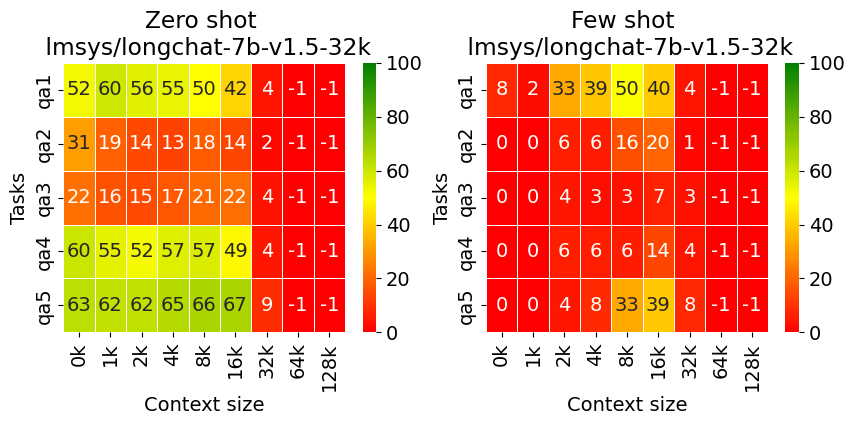

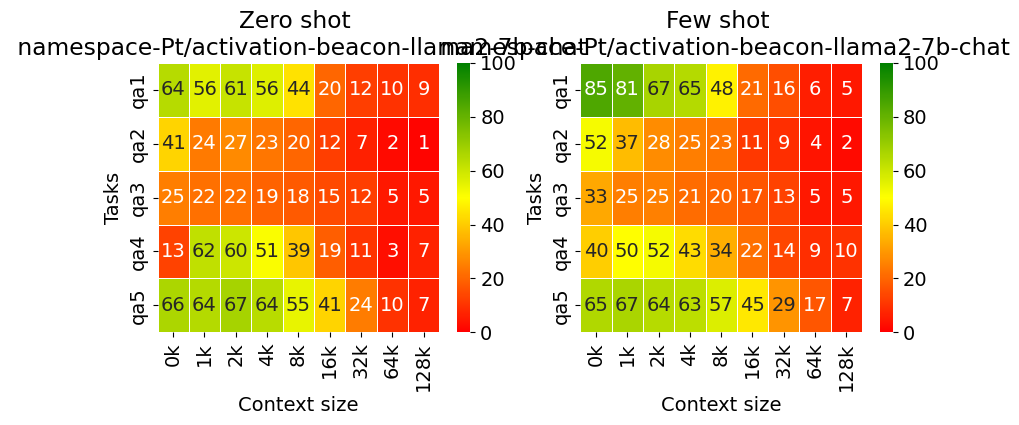

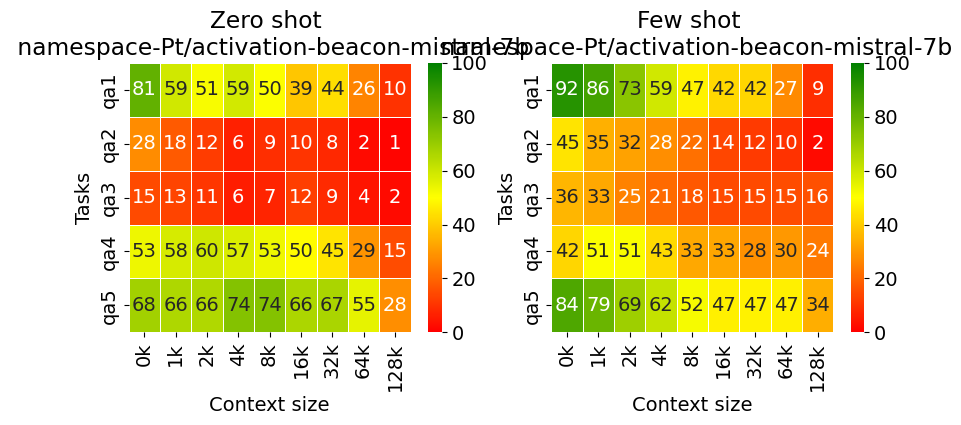

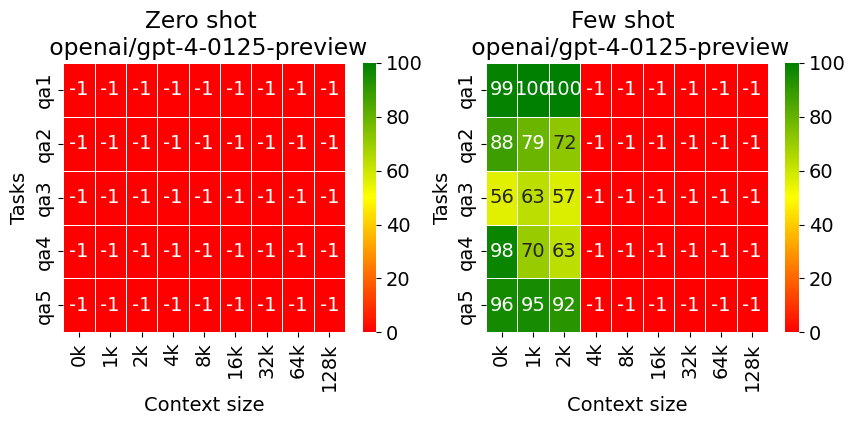

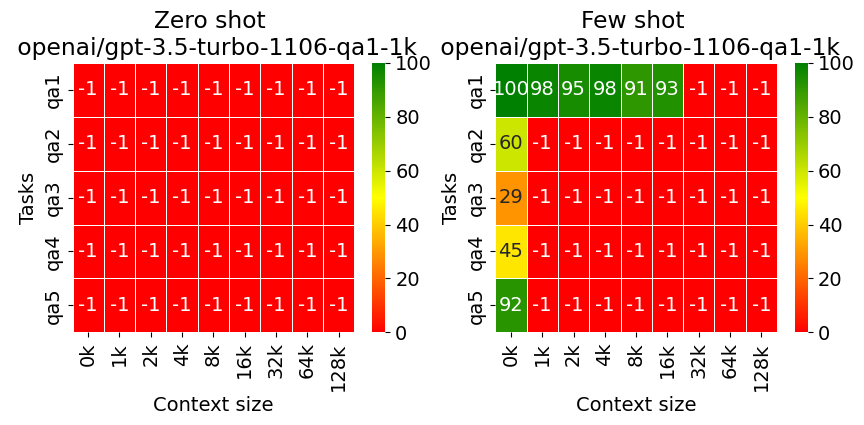

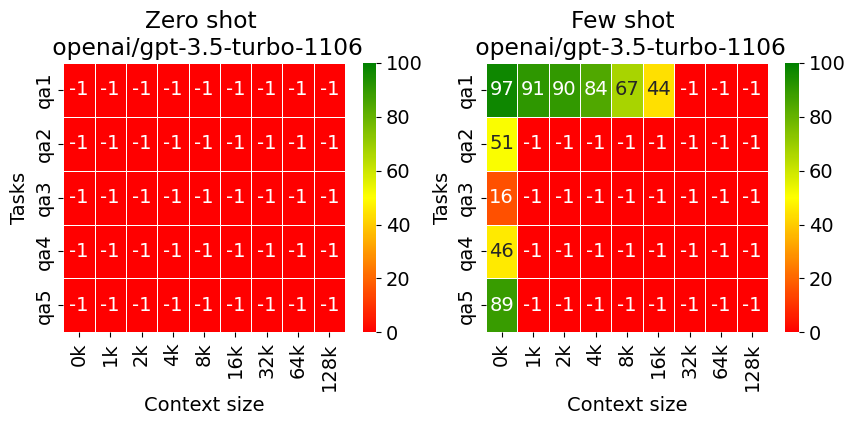

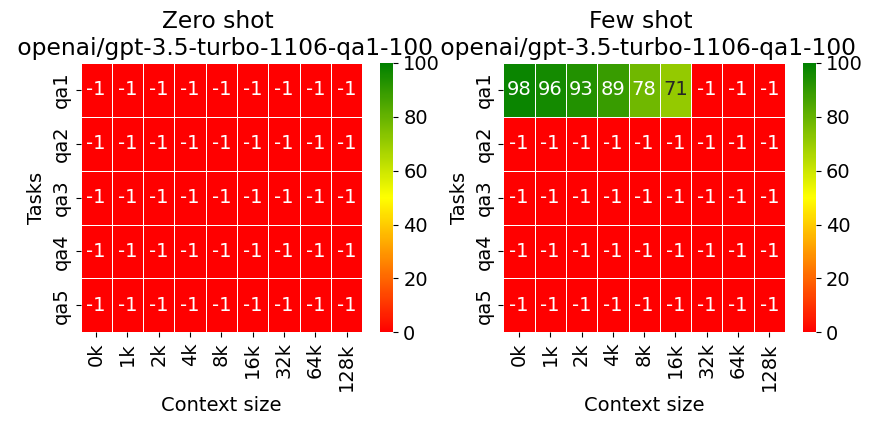

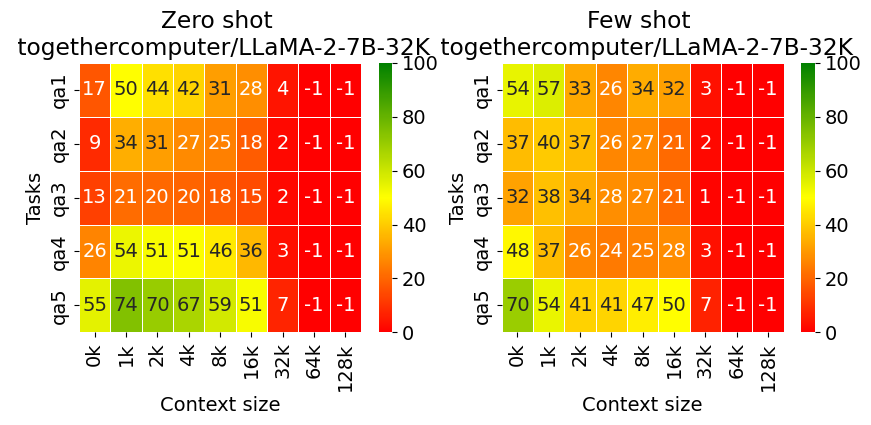

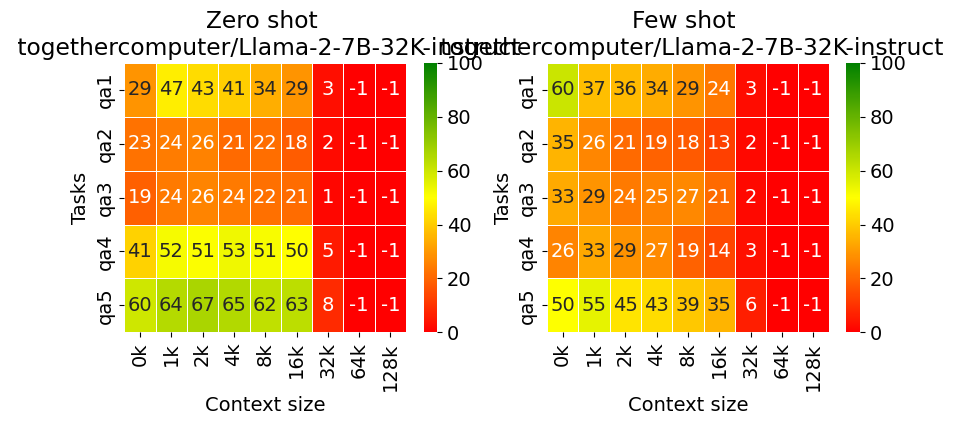

In [35]:
results = {}
for model_name in model_names:
    prompt_name = 'instruction_no_examples_no_post_prompt_no'
    accuracy = np.ones((len(tasks), len(lengths))) * -1
    try:
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = get_fname(results_folder, model_name, task, ctx_length, prompt_name)
                if fname is None:
                    continue
                
                df = pd.read_csv(fname)
                
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'], question=row['question'],
                                                                     task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

        prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'
        accuracy_fs = np.ones((len(tasks), len(lengths))) * -1
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = get_fname(results_folder, model_name, task, ctx_length, prompt_name)
                if fname is None:
                    continue
                
                df = pd.read_csv(fname)
                
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'], question=row['question'],
                                                                     task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy_fs[j, i] = 100 * score / len(df) if len(df) > 0 else 0

        results[model_name] = {'zero': accuracy, 'few': accuracy_fs}
        

        # Set large font sizes for better visibility in the PDF
        matplotlib.rc('font', size=14)

        # Create a colormap for the heatmap
        cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

        # Create the heatmap
        fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))  # Adjust the size as necessary
        
        sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[0])
        
        sns.heatmap(accuracy_fs, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[1])
        
        ax[0].set_title(f'Zero shot \n {model_name}')
        ax[1].set_title(f'Few shot \n {model_name}')
        ax[0].set_xlabel('Context size')
        ax[1].set_xlabel('Context size')
        ax[0].set_ylabel('Tasks')
        ax[1].set_ylabel('Tasks')

        # Save the figure to a PDF
        # plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
        plt.show()
    except KeyError as e:
        print(f"question not found in {model_name}")
        continue
        

### Visualize the results for copy-paste format

In [14]:
results.keys()

dict_keys(['01-ai/Yi-34B', '01-ai/Yi-34B-200k', '01-ai/Yi-9B-200k', 'NousResearch/Meta-Llama-3-8B-Instruct', 'NousResearch/Yarn-Mistral-7b-128k', 'RAG_Llama-3', 'gpt2', 'CohereForAI/c4ai-command-r-v01', 'ai21labs/Jamba-v0.1', 'microsoft/Phi-3-mini-128k-instruct', 'microsoft/Phi-3-medium-128k-instruct', 'mistralai/Mistral-7B-Instruct-v0.2', 'mistralai/Mistral-7B-Instruct-v0.2-qa1', 'mistralai/Mistral-7B-Instruct-v0.2-qa2', 'mistralai/Mixtral-8x22B-Instruct-v0.1', 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'THUDM/chatglm3-6b-128k', 'Yukang/LongAlpaca-13B', 'lmsys/longchat-7b-v1.5-32k', 'namespace-Pt/activation-beacon-llama2-7b-chat', 'namespace-Pt/activation-beacon-mistral-7b', 'openai/gpt-4-0125-preview', 'openai/gpt-3.5-turbo-1106-qa1-1k', 'openai/gpt-3.5-turbo-1106', 'openai/gpt-3.5-turbo-1106-qa1-100', 'togethercomputer/LLaMA-2-7B-32K', 'togethercomputer/Llama-2-7B-32K-instruct'])

In [15]:
mn = "microsoft/Phi-3-mini-128k-instruct"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k,512k,1M
qa1,97,85,72,69,70,60,53,38,1,-1,-1
qa2,57,39,39,38,34,23,22,15,2,-1,-1
qa3,32,41,31,27,26,24,21,22,4,-1,-1
qa4,53,51,54,46,45,47,41,44,5,-1,-1
qa5,74,72,68,70,66,68,65,55,23,-1,-1
